In [139]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.stats import zscore
import glob
from myvtk.GetMakeVtk import GetMyVtk, makeVtkFile, measure_length
import pandas as pd
from scipy.spatial.transform import Rotation as R
from procrustes import orthogonal
from myvtk.General import *
from datetime import datetime
# import geomstats.geometry.pre_shape as pre_shape
# import geomstats.geometry.discrete_curves as dc
# from geomstats.geometry.euclidean import EuclideanMetric
# from geomstats.geometry.hypersphere import HypersphereMetric
from scipy.spatial import distance
from myvtk.centerline_preprocessing import *
from scipy import interpolate
import matplotlib
import matplotlib.cm as cm
from scipy.spatial.distance import euclidean
from myvtk.customize_pca import *
# from myvtk.make_fig import *
import shutil
import os
# from myvtk.dtw import *
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
from myvtk.scores import *
import csv
from sklearn.manifold import TSNE
from scipy.interpolate import griddata
from scipy.stats import multivariate_normal, kde
import seaborn as sns
import copy
import joblib
from myvtk.geometry import *
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap

shapetype = pd.read_csv("./UVCS_class.csv", header=None)
print (shapetype)

ill=pd.read_csv("./illcases.txt",header=None)
ill = np.array(ill[0])
# print (ill)
pre_files = glob.glob("./scaling/resamp_attr_ascii/vmtk64a/*.vtk")
# print (pre_files)
unaligned_curves = []
Files = []
radii = []
Curvatures = []
Torsions = []
Typevalues = [] 
# window size
window_size = 4
# calculate moving averages using numpy convolve
weights = np.repeat(1.0, window_size)/window_size
for idx in range(len(pre_files)):
    # filename = pre_files[idx].split("\\")[-1].split(".")[0][:-8]
    filename = os.path.splitext(os.path.basename(pre_files[idx]))[0][:-8]
    print (filename)
    if filename in ill:
        print (filename, "is found in illcases.txt, skip")
        continue
    # print (filename)
    new_type_value = shapetype.loc[shapetype[0] == filename, 2].iloc[0]
    Typevalues.append(new_type_value)
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent, fnormal, fbinormal = GetMyVtk(pre_files[idx], frenet=1)
    Files.append(pre_files[idx])
    pt = pt-np.mean(pt,axis=0)
    unaligned_curves.append(pt)
    radii.append(Radius)
    sma_curv = np.convolve(Curv, weights, 'valid')
    Curvatures.append(sma_curv)
    sma_tors = np.convolve(Tors, weights, 'valid')
    Torsions.append(sma_tors)
unaligned_curves = np.array(unaligned_curves)


                0     1           2    3
0        Filename  Type  TypeManual  NaN
1     BG0002_Left     U         ill  NaN
2    BG0002_Right     U         ill  NaN
3     BG0014_Left     U           U  NaN
4     BG0019_Left     U           V  NaN
..            ...   ...         ...  ...
100   BH0031_Left     C           V  NaN
101  BH0037_Right     C           U  NaN
102   BI0001_Left     C           V    C
103   BH0016_Left     S           S  NaN
104   BH0040_Left     S         ill  NaN

[105 rows x 4 columns]
BG0002_Left
BG0002_Left is found in illcases.txt, skip
BG0002_Right
BG0002_Right is found in illcases.txt, skip
BG0014_Left
BG0014_Right
BG0019_Left
BG0019_Right
BG0020_Left
BG0020_Right
BG0021_Left
BG0021_Left is found in illcases.txt, skip
BG0021_Right
BG0022_Left
BG0022_Right
BG04_Left
BG04_Right
BG09_Left
BG09_Right
BG10_Left
BG10_Right
BG11_Left
BG11_Right
BG12_Left
BG12_Right
BG13_Left
BG13_Right
BG15_Left
BG15_Right
BG17_Left
BG17_Right
BG18_Left
BG18_Right
BH0002_Left
BH0

In [146]:
aneurisk_file = glob.glob("./aneurisk/aligned/*.vtk")
aneurisk_curves = []
for i in range(len(aneurisk_file)):
    filename = os.path.splitext(os.path.basename(aneurisk_file[i]))[0]
    # print (filename)
    pt, Curv, Tors, Radius, Abscissas, ptns, ftangent, fnormal, fbinormal = GetMyVtk(aneurisk_file[i], frenet=1)
    aneurisk_curves.append(pt-np.mean(pt, axis=0))

aneurisk_curves = np.array(aneurisk_curves)


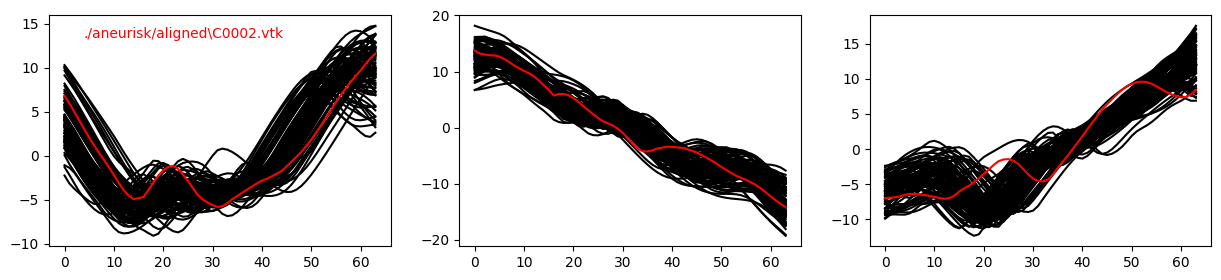

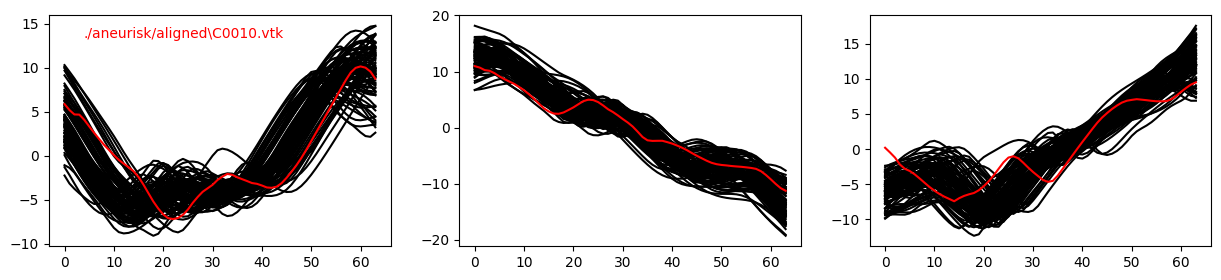

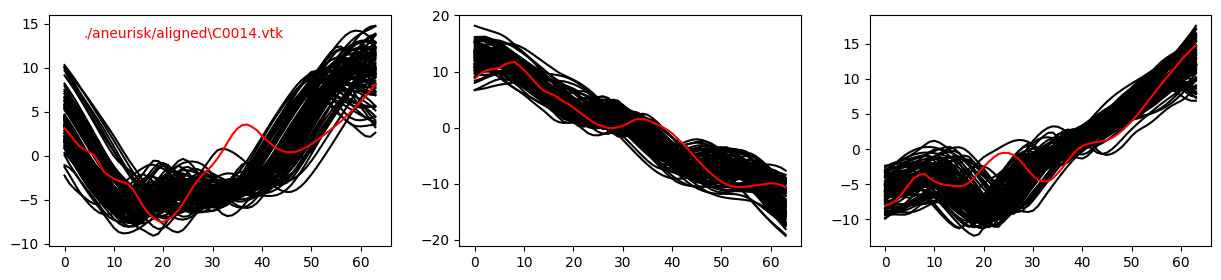

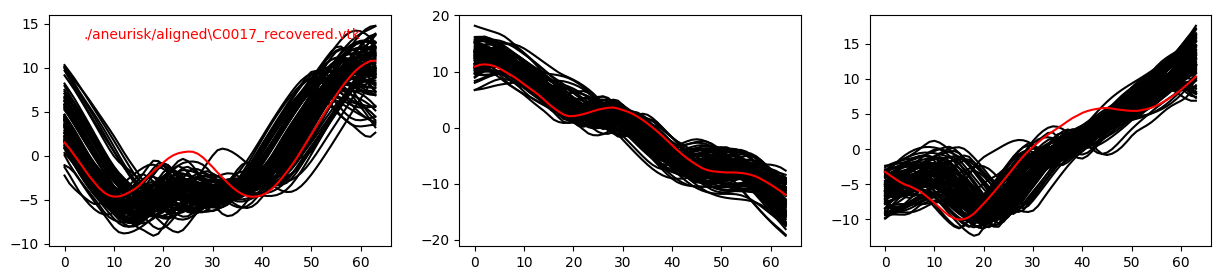

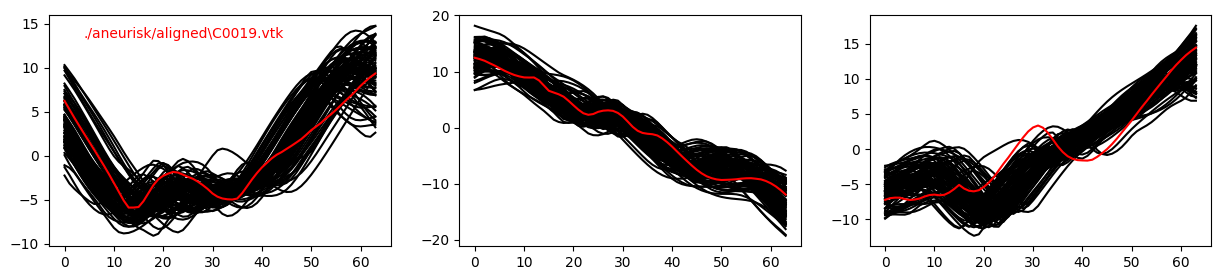

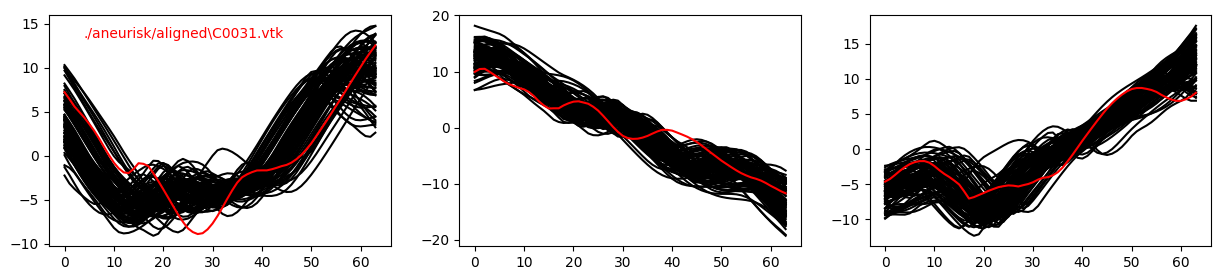

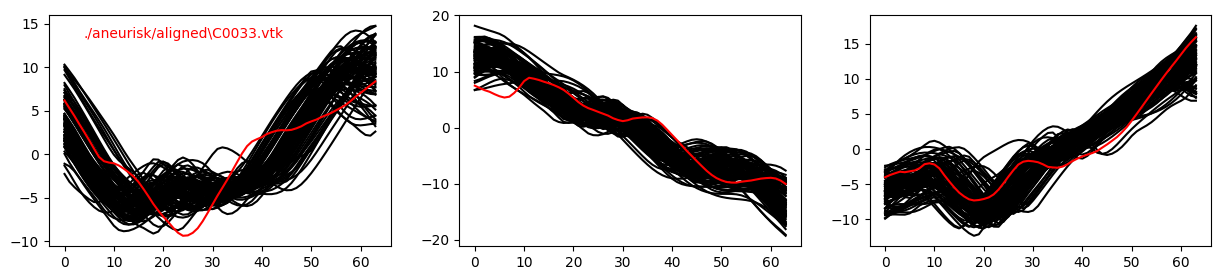

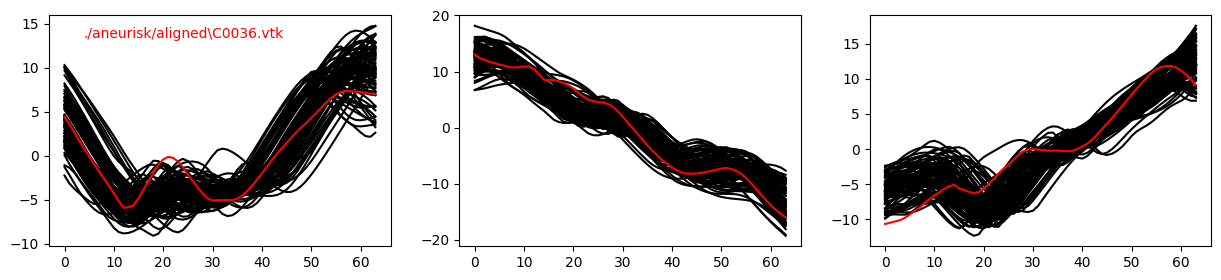

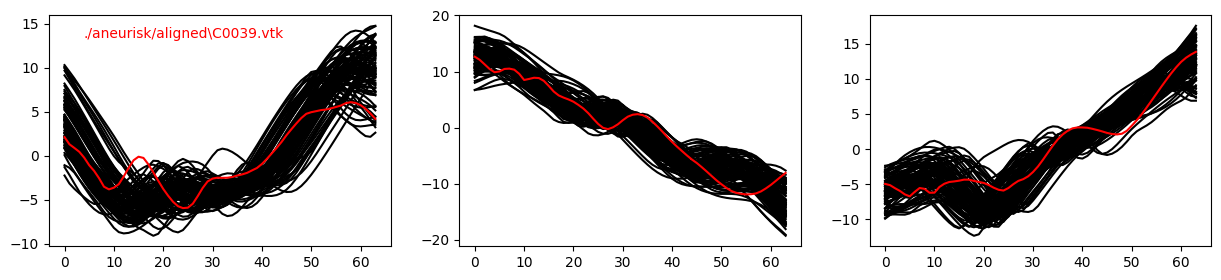

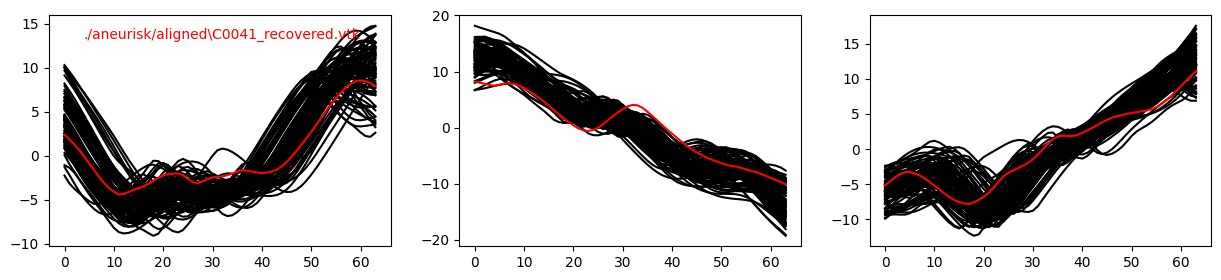

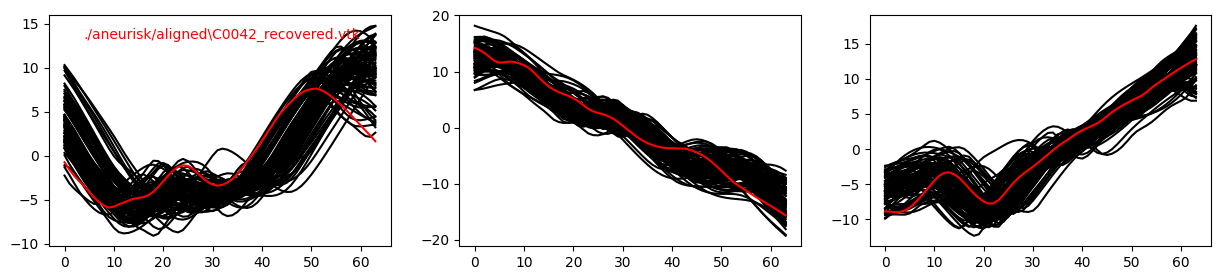

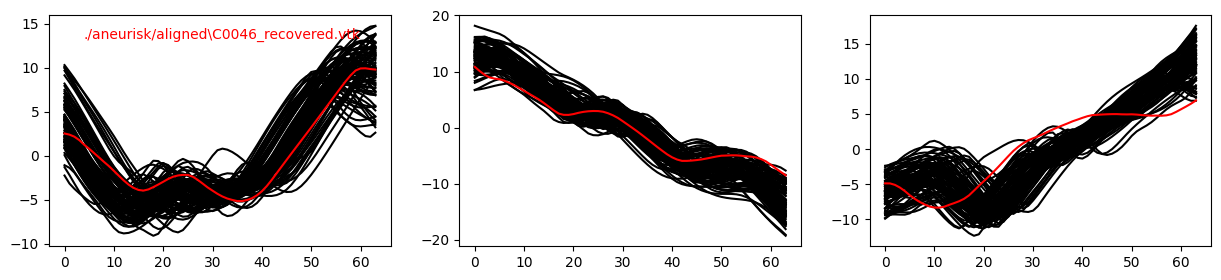

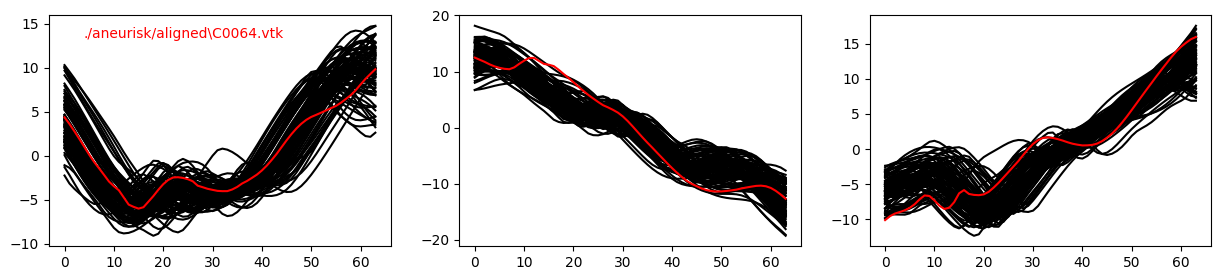

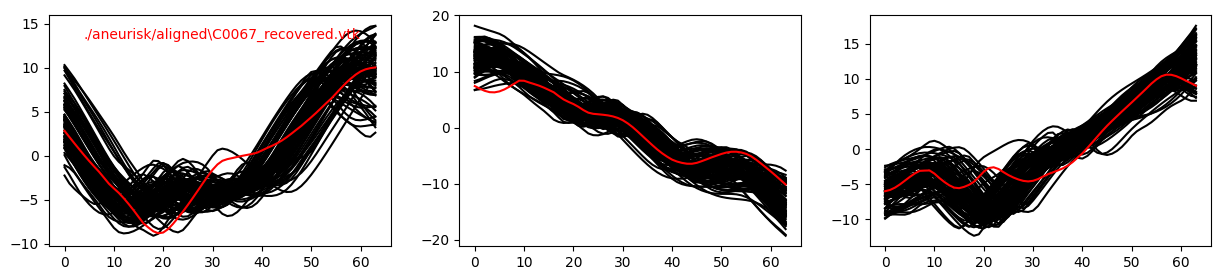

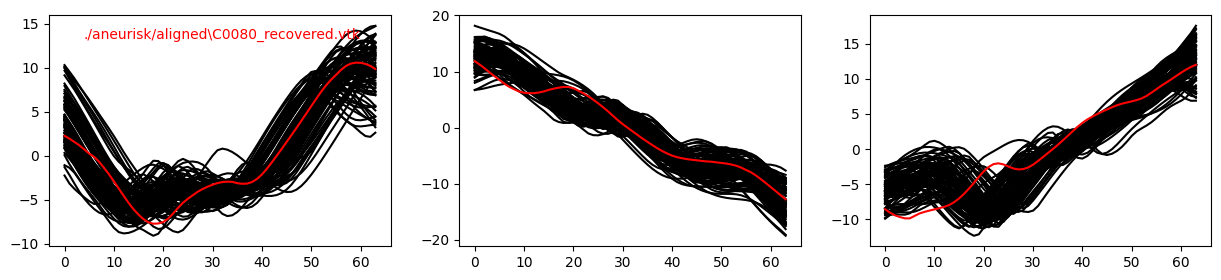

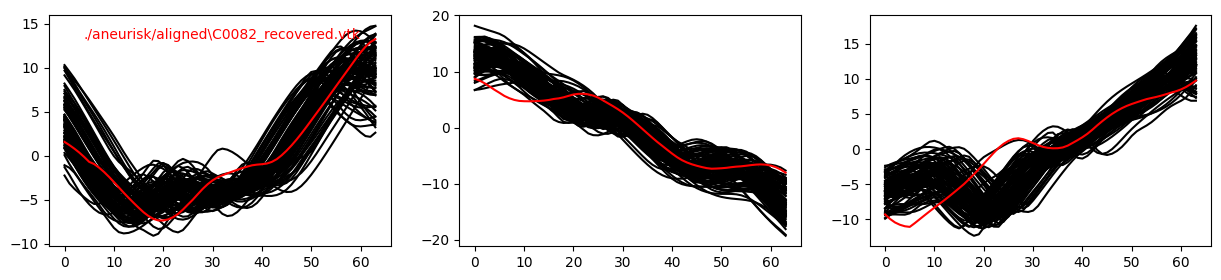

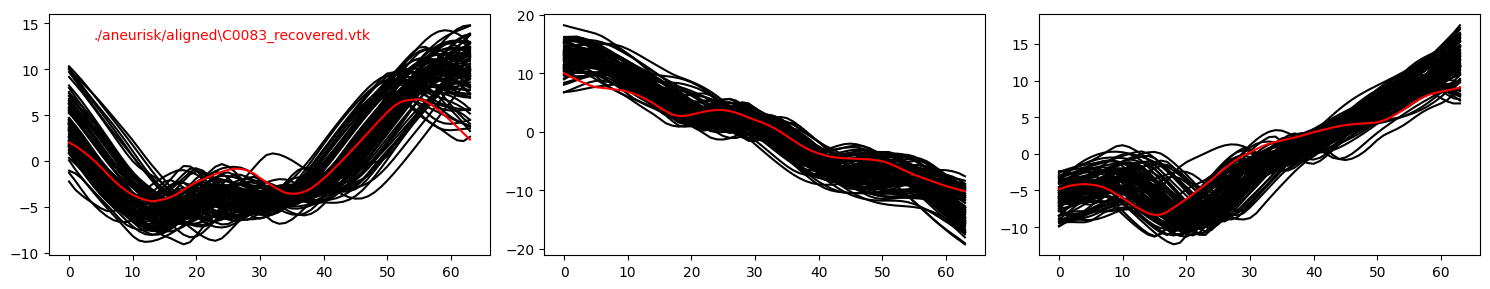

In [148]:
for i in range(len(aneurisk_curves)):
    fig = plt.figure(figsize=(15,3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    for j in range(len(unaligned_curves)):
        ax1.plot(unaligned_curves[j][:,0], color="k")
        ax2.plot(unaligned_curves[j][:,1], color="k")
        ax3.plot(unaligned_curves[j][:,2], color="k")
    ax1.plot(aneurisk_curves[i][:,0], color="r")
    ax2.plot(aneurisk_curves[i][:,1], color="r")
    ax3.plot(aneurisk_curves[i][:,2], color="r")
    ax1.annotate(aneurisk_file[i], xy=(0.1, 0.9), xycoords="axes fraction", color="r")
    

    
plt.tight_layout()
plt.show()

In [141]:
import numpy as np
from scipy import interpolate

def interpolate_cut(new_curve, num_points=64):
    # 计算累积距离作为插值参数
    distance = np.append([0], np.cumsum(np.sqrt(np.sum(np.diff(new_curve, axis=0)**2, axis=1))))
    interpolator_x = interpolate.interp1d(distance, new_curve[:, 0], kind='linear')
    interpolator_y = interpolate.interp1d(distance, new_curve[:, 1], kind='linear')
    interpolator_z = interpolate.interp1d(distance, new_curve[:, 2], kind='linear')

    # 创建新的等距参数值
    new_distance = np.linspace(distance[0], distance[-1], num_points)

    # 使用新的参数值计算插值结果
    new_curve_x = interpolator_x(new_distance)
    new_curve_y = interpolator_y(new_distance)
    new_curve_z = interpolator_z(new_distance)

    # 将结果合并为一个(64, 3)的数组
    interpolated_curve = np.column_stack([new_curve_x, new_curve_y, new_curve_z])
    
    return interpolated_curve


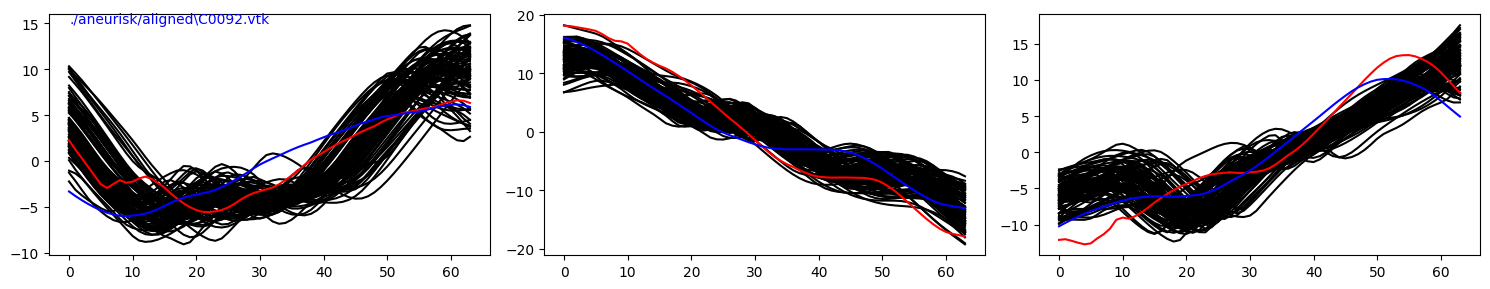

In [138]:
# for i in range(len(aneurisk_curves)):
name = "C0092"
i = -1
for q in range(len(aneurisk_file)):
    if name in aneurisk_file[q]:
        break
i = q

new_curve = aneurisk_curves[i][15:]
new_curve = interpolate_cut(new_curve)

new_curve = new_curve -np.mean(new_curve, axis=0)
result = orthogonal(new_curve, np.mean(unaligned_curves,axis=0), translate=True, scale=True)
fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
for j in range(len(unaligned_curves)):
    ax1.plot(unaligned_curves[j][:,0], color="k")
    ax2.plot(unaligned_curves[j][:,1], color="k")
    ax3.plot(unaligned_curves[j][:,2], color="k")
ax1.plot(aneurisk_curves[i][:,0], color="r")
ax2.plot(aneurisk_curves[i][:,1], color="r")
ax3.plot(aneurisk_curves[i][:,2], color="r")

ax1.plot(new_curve[:,0], color="b")
ax2.plot(new_curve[:,1], color="b")
ax3.plot(new_curve[:,2], color="b")

ax1.annotate(aneurisk_file[i], (0,15), color="b")
plt.tight_layout()
plt.show()

In [137]:
# new_filename = aneurisk_file[i].split(".v")[0]+"_recovered.vtk"
# makeVtkFile(new_filename, new_curve, [],[])

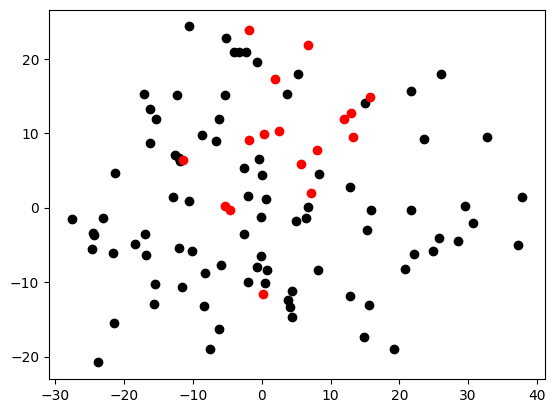

In [156]:
pca = PCA(n_components=3)
res = pca.fit_transform(unaligned_curves.reshape(len(unaligned_curves),64*3))
plt.scatter(res[:,0],res[:,1],c='k')
aneures = pca.transform(aneurisk_curves.reshape(len(aneurisk_curves),64*3))
plt.scatter(aneures[:,0],aneures[:,1],c='r')